In [1]:
# Base libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ARIMA and VAR model libaries
from statsmodels.tsa.stattools import adfuller, grangercausalitytests, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.api import VAR

# Random Forest libraries
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from scipy.stats import norm

# Hide warning messages to read outputs easier
import warnings
warnings.filterwarnings("ignore")

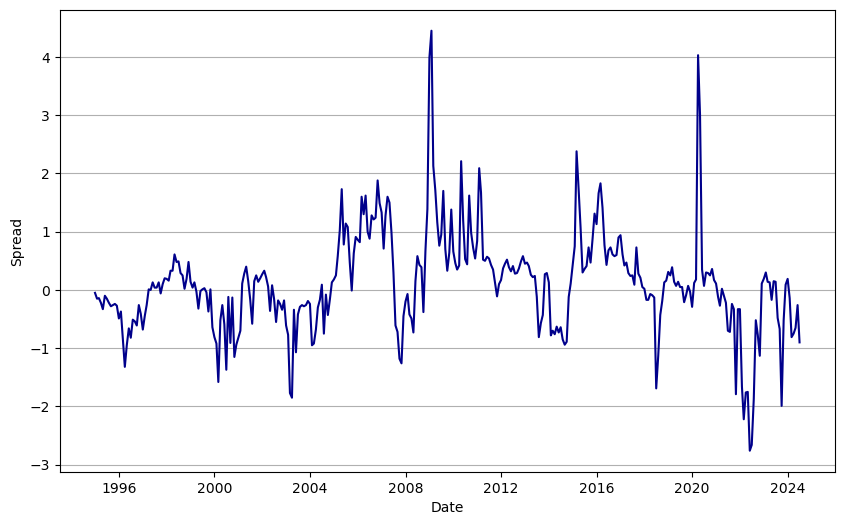

In [73]:
industry_monthly_data = pd.read_excel('Oil Data.xlsx', sheet_name='Industry_M')
macro_data = pd.read_excel('Oil Data.xlsx', sheet_name='Macro_M')
stock_prices = pd.read_excel('Oil Data.xlsx', sheet_name='StockPrices_M')

industry_monthly_data['Spread'] = industry_monthly_data['CL2'] - industry_monthly_data['CL1']

industry_monthly_data['Date'] = pd.to_datetime(industry_monthly_data['Date'])
macro_data['Date'] = pd.to_datetime(macro_data['Date'])
stock_prices['Date'] = pd.to_datetime(stock_prices['Date'])

last_date = industry_monthly_data['Date'].max()

industry_monthly_data['Date'] = industry_monthly_data['Date'].dt.to_period('M').dt.to_timestamp('M')
macro_data['Date'] = macro_data['Date'].dt.to_period('M').dt.to_timestamp('M')
stock_prices['Date'] = stock_prices['Date'].dt.to_period('M').dt.to_timestamp('M')
stock_prices = stock_prices.drop(columns=['Shell'])

merged_data = industry_monthly_data.merge(macro_data, on='Date', how='inner')
merged_data = merged_data.merge(stock_prices, on='Date', how='inner')

plt.figure(figsize=(10, 6))
plt.grid(axis='y') 
plt.plot(merged_data['Date'], merged_data['Spread'], color='darkblue')
plt.xlabel('Date')
plt.ylabel('Spread')

merged_data = merged_data.drop(columns=['CL1', 'CL2', 'Total Open Interest'])


In [90]:
# AdFuller test 
for i in merged_data:
    if i == "Date":
        continue
    adfullertest = adfuller(merged_data[i].dropna())
    if adfullertest[1] > 0.05:
        merged_data[i] = merged_data[i].diff()
merged_data_adfuller_cleaned = merged_data.dropna()
print(merged_data_adfuller_cleaned.columns)

# KPSS
for i in merged_data:
    if i == "Date":
        continue
    kpsstest = adfuller(merged_data[i].dropna())
    if kpsstest[1] > 0.05:
        merged_data[i] = merged_data[i].diff()
merged_data_kpss_cleaned = merged_data.dropna()

model_vars = ['Brent', 'CRKS321C Index', 'Baltic Dry Index',
       'Daily Production', 'Inventories', 'Rig Count', 'Commercial Long',
       'Commercial Short', 'Spread', 'CPI YOY %', '3M Yield', '10Y Yield',
       'IndustrialProduction Index', 'SPX', 'DXY returns', 'VIX',
       'Gasoline All Grades', 'Dow Jones US Oil&Gas Index', 'ExxonMobil',
       'ConocoPhilips', 'Chevron', 'BP ', 'TotalEnergies']
var_data = merged_data_adfuller_cleaned[model_vars]
model = VAR(var_data)
lag_order = model.select_order()
optimal_lag = lag_order.aic
print("Optimal lag:", lag_order.aic, lag_order.bic, lag_order.hqic)

Index(['Date', 'Brent', 'CRKS321C Index', 'Baltic Dry Index',
       'Daily Production', 'Inventories', 'Rig Count', 'Commercial Long',
       'Commercial Short', 'Spread', 'CPI YOY %', '3M Yield', '10Y Yield',
       'IndustrialProduction Index', 'SPX', 'DXY returns', 'VIX',
       'Gasoline All Grades', 'Dow Jones US Oil&Gas Index', 'ExxonMobil',
       'ConocoPhilips', 'Chevron', 'BP ', 'TotalEnergies'],
      dtype='object')
Optimal lag: 13 1 1


In [91]:
significant_vars = ['Spread']
for i in model_vars:
    if i != 'Spread':
        gctest = grangercausalitytests(var_data[['Spread', i]], maxlag=optimal_lag, verbose=False)
        p_values = [gctest[lag][0]['ssr_chi2test'][1] for lag in range(1, optimal_lag)]
        if any(p < 0.05 for p in p_values):
            significant_vars.append(i)
print("Signifcant variables are:", significant_vars)

Signifcant variables are: ['Spread', 'Brent', 'Baltic Dry Index', 'Daily Production', 'Inventories', 'Rig Count', 'Commercial Long', 'Commercial Short', 'CPI YOY %', 'IndustrialProduction Index', 'SPX', 'DXY returns', 'VIX', 'Gasoline All Grades', 'ConocoPhilips', 'Chevron', 'BP ', 'TotalEnergies']


R-squared on training data: 1.0
R-squared on test data: -2865.0057990893274


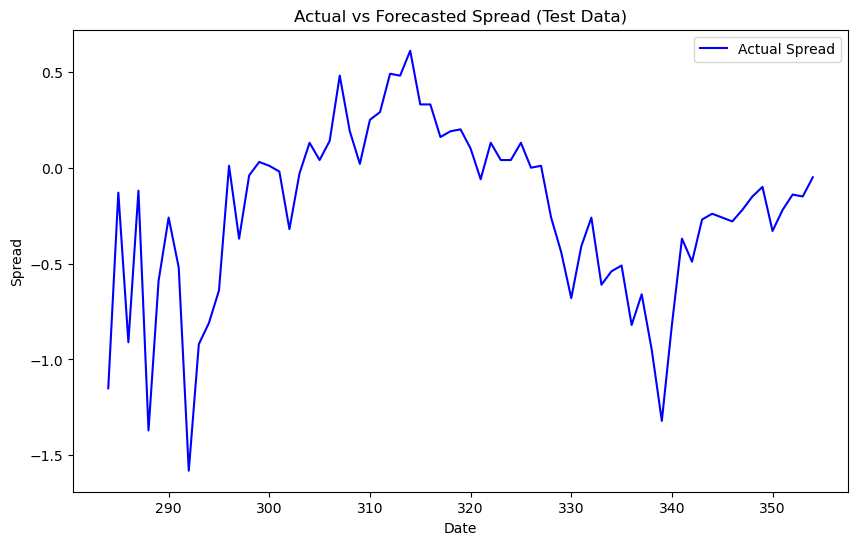

In [55]:
significant_var_data = var_data[significant_vars]
n_obs = len(significant_var_data)
train_size = int(0.8 * n_obs)
train_data = significant_var_data.iloc[:train_size]
test_data = significant_var_data.iloc[train_size:]

significant_model = VAR(train_data)
significant_results = significant_model.fit(maxlags=16)
lags = significant_results.k_ar

fitted_train = significant_results.fittedvalues
actual_train = train_data.iloc[lags:]['Spread']

def compute_r_squared(actual, predicted):
    if len(actual) != len(predicted):
        raise ValueError("The length of actual and predicted values must be the same")
    residual_sum_of_squares = np.sum((actual - predicted) ** 2)
    total_sum_of_squares = np.sum((actual - np.mean(actual)) ** 2)
    r_squared = 1 - (residual_sum_of_squares / total_sum_of_squares)
    return r_squared

r_squared_train = compute_r_squared(actual_train, fitted_train['Spread'])
print("R-squared on training data:", r_squared_train)

forecast_input = train_data.values[-lags:]
forecast_steps = len(test_data)
forecast = significant_results.forecast(y=forecast_input, steps=forecast_steps)
forecast_df = pd.DataFrame(forecast, index=test_data.index, columns=significant_var_data.columns)

actual_spread = test_data['Spread']
predicted_spread = forecast_df['Spread']

r_squared_test = compute_r_squared(actual_spread, predicted_spread)
print("R-squared on test data:", r_squared_test)

plt.figure(figsize=(10, 6))
plt.plot(actual_spread.index, actual_spread, label='Actual Spread', color='blue')
# plt.plot(predicted_spread.index, predicted_spread, label='Forecasted Spread', color='red')
plt.xlabel('Date')
plt.ylabel('Spread')
plt.title('Actual vs Forecasted Spread (Test Data)')
plt.legend()
plt.show()

R-squared: 0.5230319772800605
Mean Squared Error (MSE): 0.09389119033623186
Root Mean Squared Error (RMSE): 0.30641669395813254
Mean Absolute Error (MAE): 0.2084559420289857


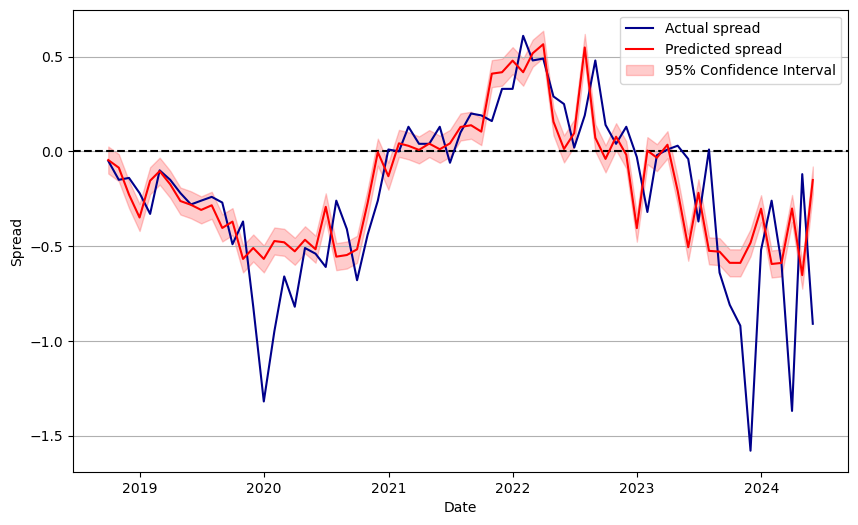

In [ ]:
lags = optimal_lag 
X = pd.concat([significant_var_data.shift(i) for i in range(1, lags+1)], axis=1).dropna()
y = significant_var_data['Spread'][lags:]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

rf_model = RandomForestRegressor(n_estimators=500)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

y_pred = y_pred[::-1]
y_test = y_test[::-1]

r_squared = r2_score(y_test, y_pred)
print(f'R-squared: {r_squared}')

mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error (MSE): {mse}')

rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f'Root Mean Squared Error (RMSE): {rmse}')

mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error (MAE): {mae}')

# Calculate residuals (errors)
residuals = y_test - y_pred

# Estimate the standard deviation of the residuals (error)
std_error = np.std(residuals)

# Calculate confidence intervals for the predictions
n = len(y_pred)
z_score = norm.ppf(0.975)
margin_of_error = z_score * (std_error / np.sqrt(n))

# Confidence intervals
ci_lower = y_pred - margin_of_error
ci_upper = y_pred + margin_of_error

merged_data_cleaned = merged_data_adfuller_cleaned.sort_values('Date')

plt.figure(figsize=(10, 6))
plt.grid(axis='y') 
plt.axhline(y = 0, color='black', linestyle='--')
plt.plot(merged_data_cleaned['Date'].iloc[-len(y_test):], y_test, label='Actual spread', color='darkblue')
plt.plot(merged_data_cleaned['Date'].iloc[-len(y_pred):], y_pred, label='Predicted spread', color='red')
plt.fill_between(merged_data_cleaned['Date'].iloc[-len(y_pred):], ci_lower, ci_upper, color='red', alpha=0.2, label='95% Confidence Interval')
plt.xlabel('Date')
plt.ylabel('Spread')
plt.legend()
plt.show()

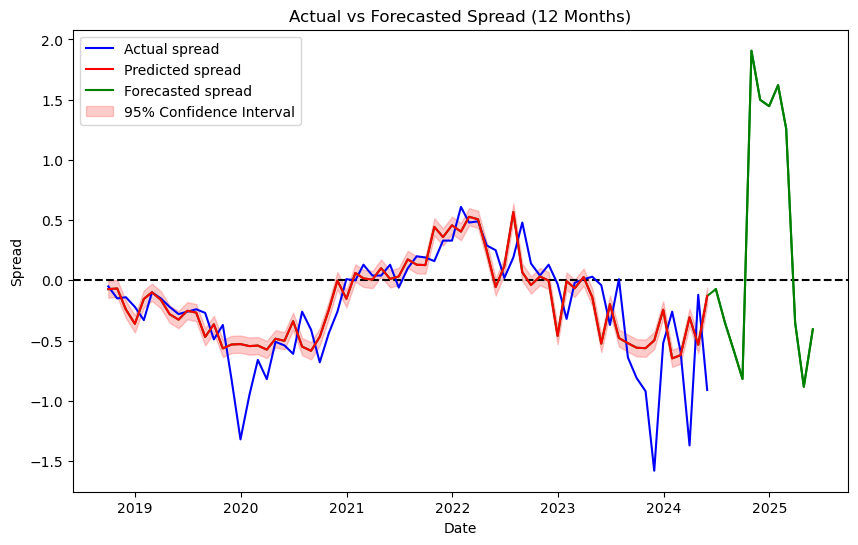

In [ ]:
from scipy.interpolate import interp1d
import matplotlib.dates as mdates

future_predictions = []
forecast_std_dev = []
forecast_period = 12
last_data = X_test.iloc[-1].values.reshape(1, -1)

for _ in range(forecast_period):
    # Predict the next value
    next_pred = rf_model.predict(last_data)[0]
    future_predictions.append(next_pred)
    
    # Update the `last_known_data` by shifting it and appending the new prediction
    # Shift all columns by one and append the new prediction at the end
    last_data = np.roll(last_data, shift=-1, axis=1)
    last_data[0, -1] = next_pred  # Append the new prediction to the last column

forecast_dates = pd.date_range(start=merged_data_cleaned['Date'].iloc[-1] + pd.Timedelta(days=1), periods=forecast_period, freq='M')
forecast_df = pd.DataFrame({
    'Date': forecast_dates,
    'Predicted Spread': future_predictions
})

# Combine predicted (y_pred) with forecasted values (future_predictions)
combined_predictions = np.concatenate([y_pred, future_predictions])

# Combine the dates of the predicted and forecasted data
combined_dates = pd.concat([
    merged_data_cleaned['Date'].iloc[-len(y_pred):],
    forecast_df['Date']
]).reset_index(drop=True)

# Create a combined DataFrame
combined_df = pd.DataFrame({
    'Date': combined_dates,
    'Predicted Spread': combined_predictions
})
combined_df = combined_df.sort_values('Date').reset_index(drop=True)

plt.figure(figsize=(10, 6))
plt.axhline(y=0, color='black', linestyle='--')
plt.plot(merged_data_cleaned['Date'].iloc[-len(y_test):], y_test, label='Actual spread', color='blue')

# Plot the combined data (red + green)
plt.plot(combined_dates, combined_predictions, color='green')

# Plot the predicted spread (red part of the line)
plt.plot(combined_df['Date'].iloc[:len(y_pred)], combined_df['Predicted Spread'].iloc[:len(y_pred)], label='Predicted spread', color='red')

# Plot the forecasted spread (green part of the line)
plt.plot(combined_df['Date'].iloc[len(y_pred):], combined_df['Predicted Spread'].iloc[len(y_pred):], label='Forecasted spread', color='green')

plt.fill_between(merged_data_cleaned['Date'].iloc[-len(y_pred):], ci_lower, ci_upper, color='red', alpha=0.2, label='95% Confidence Interval')

plt.xlabel('Date')
plt.ylabel('Spread')
plt.title('Actual vs Forecasted Spread (12 Months)')
plt.legend()

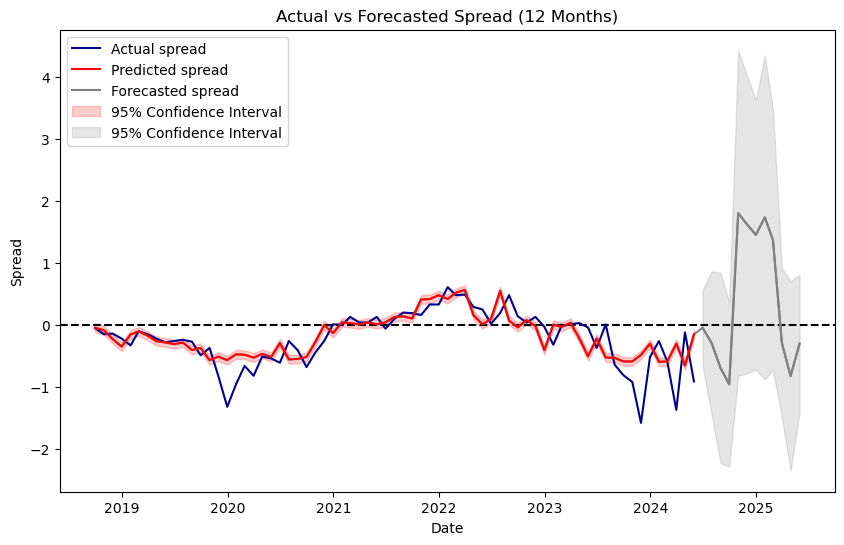

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

future_predictions = []
forecast_std_dev = []
forecast_period = 12
last_data = X_test.iloc[-1].values.reshape(1, -1)

for _ in range(forecast_period):
    # Predict using all trees in the Random Forest
    tree_predictions = np.array([tree.predict(last_data)[0] for tree in rf_model.estimators_])
    
    # Mean prediction
    next_pred = np.mean(tree_predictions)
    future_predictions.append(next_pred)
    
    # Standard deviation of predictions
    forecast_std_dev.append(np.std(tree_predictions))
    
    # Update last_data by shifting it and appending new prediction
    last_data = np.roll(last_data, shift=-1, axis=1)
    last_data[0, -1] = next_pred

# Generate forecast dates
forecast_dates = pd.date_range(start=merged_data_cleaned['Date'].iloc[-1] + pd.Timedelta(days=1), 
                               periods=forecast_period, freq='M')

# Convert forecasted values and standard deviation into DataFrame
forecast_df = pd.DataFrame({
    'Date': forecast_dates,
    'Predicted Spread': future_predictions,
    'Std Dev': forecast_std_dev
})

# Compute 95% confidence interval
z_score = norm.ppf(0.975)  # 1.96 for 95% confidence
forecast_df['Lower Bound'] = forecast_df['Predicted Spread'] - (z_score * forecast_df['Std Dev'])
forecast_df['Upper Bound'] = forecast_df['Predicted Spread'] + (z_score * forecast_df['Std Dev'])

# Combine predicted (y_pred) with forecasted values (future_predictions)
combined_predictions = np.concatenate([y_pred, future_predictions])

# Combine the dates of the predicted and forecasted data
combined_dates = pd.concat([
    merged_data_cleaned['Date'].iloc[-len(y_pred):],
    forecast_df['Date']
]).reset_index(drop=True)

# Create a combined DataFrame
combined_df = pd.DataFrame({
    'Date': combined_dates,
    'Predicted Spread': combined_predictions
}).sort_values('Date').reset_index(drop=True)

plt.figure(figsize=(10, 6))
plt.axhline(y=0, color='black', linestyle='--')

# Plot actual values
plt.plot(merged_data_cleaned['Date'].iloc[-len(y_test):], y_test, label='Actual spread', color='darkblue')

plt.plot(combined_dates, combined_predictions, color='grey')

# Plot predicted values (red)
plt.plot(combined_df['Date'].iloc[:len(y_pred)], combined_df['Predicted Spread'].iloc[:len(y_pred)], label='Predicted spread', color='red')

# Plot forecasted values (green)
plt.plot(combined_df['Date'].iloc[len(y_pred):], combined_df['Predicted Spread'].iloc[len(y_pred):], label='Forecasted spread', color='grey')

# Confidence interval band for the forecast
plt.fill_between(merged_data_cleaned['Date'].iloc[-len(y_pred):], ci_lower, ci_upper, color='red', alpha=0.2, label='95% Confidence Interval')
plt.fill_between(forecast_df['Date'], forecast_df['Lower Bound'], forecast_df['Upper Bound'], color='grey', alpha=0.2, label='95% Confidence Interval')

plt.xlabel('Date')
plt.ylabel('Spread')
plt.title('Actual vs Forecasted Spread (12 Months)')
plt.legend()

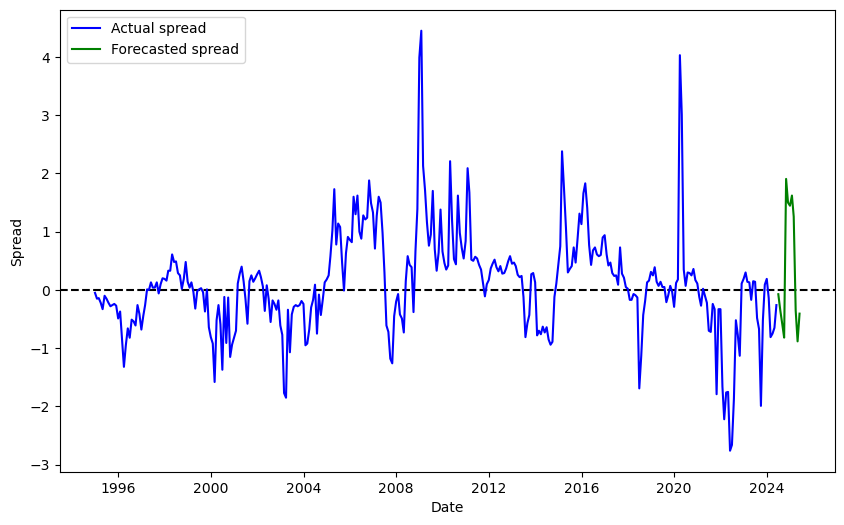

In [99]:
plt.figure(figsize=(10, 6))
plt.axhline(y=0, color='black', linestyle='--')
plt.plot(merged_data_cleaned['Date'], merged_data_cleaned['Spread'], label='Actual spread', color='blue')
plt.plot(combined_df['Date'].iloc[len(y_pred):], combined_df['Predicted Spread'].iloc[len(y_pred):], label='Forecasted spread', color='green')
plt.xlabel('Date')
plt.ylabel('Spread')
plt.legend()